# Functional activity level reported by an informant is an early predictor of Alzheimer's disease

## Features
1. 'AGE'
1. 'RAVLT\_immediate'
1. 'AVDEL30MIN\_neuro'
1. 'AVDELTOT\_neuro'
1. 'TRAASCOR\_neuro'
1. 'TRABSCOR\_neuro'
1. 'CATANIMSC\_neuro'
1. 'GDTOTAL\_gds'
1. 'LRHHC\_n\_long'
1. 'LRLV\_n\_long'
1. 'FAQ'
1. 'Gender\_num\_'
1. 'Subgroup\_'
1. 'Subgroup\_num\_'
1. 'Usage\_'
---

**Resources**
1. DATA
    1. [data/data2](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2) - csv files downloaded from ADNI,
1. RESULTS
    1. [results/20210420](https://github.com/MMIV-ML/MCI-subgroups/tree/master/results/20210420) - result folder.

   
   
   *Created: 2022.10.10 / Updated: 2022.10.14*
   
---

#### IMPORTS

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import eli5
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from pdpbox import pdp
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import display, SVG, Image
from eli5.sklearn import PermutationImportance

In [3]:
import ad

In [4]:
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold


from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.inspection import plot_partial_dependence

#### GLOBAL PATH VARIABLES

In [5]:
# Notebook folder
NB_DIR = %pwd
NB_DIR = Path(NB_DIR)
# Root MCI foler
ROOT_DIR = NB_DIR.parent/'AV_paper_revision_first_cleaned_20221012'
# Main data folder (with downloaded csv files)
MAIN_DATA_DIR = ROOT_DIR/'source-data'
DATA_DIR_FS = ROOT_DIR / 'source-data'
# Current data dir with sMCI_cAD.csv & bl.csv files
CURRENT_DATA_DIR = ROOT_DIR/'results'
CURRENT_DATA_DIR.mkdir(parents=True, exist_ok=True)
# Results folder
RESULTS_DIR = ROOT_DIR/'results' #misclassified patient table
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

#### INSTALLED PACKAGES INFO

In [6]:
if 1:
    packages = ['numpy', 'scipy', 'seaborn', 'pandas', 'matplotlib',
                'ipywidgets', 'eli5', 'pdpbox', 'sklearn']
    display(ad.package_versions(installedOnly=False, theMostImportant=packages))



Computer name: mk-prec-7540
Operating system: Linux, 64bit

Python path: /home/marek/miniconda3/envs/mci/bin/python
Python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]



module version
4         eli5  0.11.0
6   ipywidgets   7.6.5
10  matplotlib   3.4.2
13       numpy  1.21.2
15      pandas   1.3.4
16      pdpbox   0.2.1
20       scipy   1.7.1
21     seaborn  0.11.2
23     sklearn     1.0

---

##  FEATURES TO FEED A MODEL

In [7]:
FEATURES = ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
            'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro',
            'GDTOTAL_gds', 'LRHHC_n_long','LRLV_n_long', 'FAQ',
            'Subgroup_', 'Subgroup_num_', 'Usage_',
           'Gender_num_', 'PTGENDER'
           ]

FEATURE_RENAMING = {"TRAASCOR_neuro":"TMTA", "TRABSCOR_neuro":"TMTB", 
                    "CATANIMSC_neuro":"CFT", "GDTOTAL_gds":"GDS", "LRHHC_n_long":"HC", 
                    "LRLV_n_long":"LVV", "RAVLT_immediate":"RAVLT-Im", 
                    "AVDEL30MIN_neuro":"RAVLT-Delay", "AVDELTOT_neuro":"RAVLT-Recog" }


# Filename prefixes used to save all results (tables, images, ...)
FILE_NAME_PREFIX = '1.00-faq-predictor-of-ad'
FILE_NAME_NUMBER = FILE_NAME_PREFIX.split('_')[0]


FILE_NAME_WITH_GS_MODEL_TO_LOAD = '1.00-faq-predictor-of-ad'

# random state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# folds 
FOLDS = 10

# display all stuff
VERBOSE = True

---

## LOAD BASELINE FILE AND RESTRICT COLUMN RANGE TO SELECTED FEATURES ONLY (FEATURES List + Subgroup\_ x2 + Usage\_)

In [8]:
bl_name = MAIN_DATA_DIR / 'bl.csv'
bl_loaded = pd.read_csv(bl_name, index_col=0)

bl_sel_feat = bl_loaded[FEATURES]

print(f'Subjects: \t{bl_sel_feat.shape[0]}')
print(f'Columns: \t{bl_sel_feat.shape[1]}')

Subjects: 	708
Columns: 	16


### SPLIT BETWEEN TRAIN AND TEST SUBSETS

In [9]:
bl_train = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'train']
bl_test = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'test']

# a list of both sets, to ease forfurther manipulation
bl_sets = [['Train set', bl_train], ['Test set', bl_test]]

---

## TRAIN / TEST SETS SHORT INFO

In [10]:
if VERBOSE: 
    print('Subjects in:')
    for name, bl in bl_sets:
        print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/bl_sel_feat.shape[0] * 100:.0f}%)')

    print('\n\nSubjects in each subgroup (with NaN included):\n')
    for name, bl in bl_sets:
        print(f'*** {name} ***\n{bl.Subgroup_.value_counts().to_string()}\n')

Subjects in:
	Train set:	566 (80%)
	Test set:	142 (20%)


Subjects in each subgroup (with NaN included):

*** Train set ***
sMCI    305
cAD     261

*** Test set ***
sMCI    76
cAD     66



#### PRINT COLUMN NAMES INCLUDED IN BOTH SETS

In [11]:
ad.included_feature_info(bl_train, pattern='adni-neuro-long-_')

Total number of columns: 16



adni (#4)        neuro (#5)     long (#2)      ours (#4)
0              AGE  AVDEL30MIN_neuro  LRHHC_n_long    Gender_num_
1              FAQ    AVDELTOT_neuro   LRLV_n_long      Subgroup_
2         PTGENDER   CATANIMSC_neuro                Subgroup_num_
3  RAVLT_immediate    TRAASCOR_neuro                       Usage_
4                     TRABSCOR_neuro

---

## DROP `NaN` VALUES IN TRAIN AND TEST SETS (IF ANY)

In [12]:
print('\nSubjects number in both sets AFTER dropping NaN values:\n')
for name, bl in bl_sets:
    bl.dropna(axis='rows', inplace=True)
    print(f' - {name}: {bl.shape[0]}')


Subjects number in both sets AFTER dropping NaN values:

 - Train set: 540
 - Test set: 140


---

# RANDOM FORESTS CLASSIFICATION

---

## CREATE X AND y

In [13]:
# train set
X_train = bl_train.copy(deep=True)
y_train = X_train.Subgroup_num_

# test set
X_test = bl_test.copy(deep=True)
y_test = X_test.Subgroup_num_

# a list of both sets, to ease forfurther manipulation
X_sets = [['X train set', X_train], ['X test set', X_test]]
y_sets = [['y train set', y_train], ['y test set', y_test]]

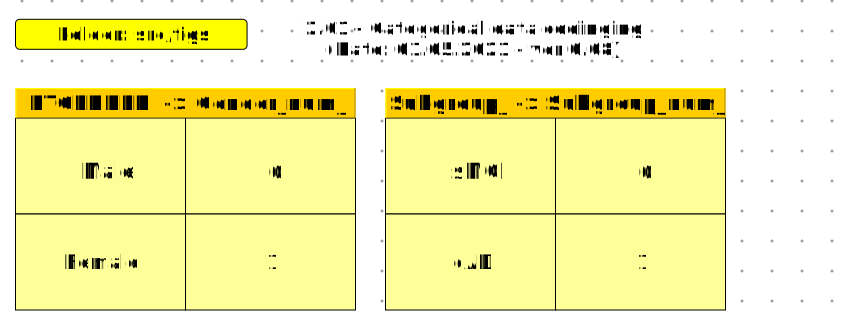

In [14]:
SVG(filename='figs/2.01_preprocessing_categorical_2_num.svg')

---

## REMOVE `SUBGROUP_`, `Subgroup_num_` and `Usage_` COLUMNS FROM THE TRAIN & TEST SETS

In [15]:
print('From:')
for name, X in X_sets:
    print(f'\t{name}')
    
    for feat in ['Subgroup_', 'Subgroup_num_', 'Usage_', 'Gender_num_', 'PTGENDER']:
        if feat in X.columns: X.drop(columns=feat,inplace=True); print(f'\t\tRemoved: {feat}')

From:
	X train set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_
		Removed: Gender_num_
		Removed: PTGENDER
	X test set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_
		Removed: Gender_num_
		Removed: PTGENDER


In [16]:
# Check the current features in the train set and the test set
print('Column names in:\n')
for name, X in X_sets:
    print(f'- {name}:\n  {X.columns.to_list()}\n')

Column names in:

- X train set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long', 'FAQ']

- X test set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long', 'FAQ']



---

# LOAD GRID SEARCH RESULTS FROM A FILE

In [17]:
file_name_prefix_ext =  FILE_NAME_WITH_GS_MODEL_TO_LOAD + '-GS-model.pkl'
file_name_prefix_path = MAIN_DATA_DIR / file_name_prefix_ext

print(f"GridSearch parameters loaded from a file:\n\t\t{file_name_prefix_path}")
grid = joblib.load(file_name_prefix_path)     
    
clf = grid.best_estimator_

print()
print(f'Best score: {grid.best_score_:.3f}\n')

print(f'Best params:')
for k,v in grid.best_params_.items():
    print(f'\t{k}: {v}')
    
# save best params to a global variable
print('\nBest params are stored in the variable: BEST_PARAMS')
BEST_PARAMS = grid.best_params_

GridSearch parameters loaded from a file:
		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/AV_paper_revision_first_cleaned_20221012/source-data/1.00-faq-predictor-of-ad-GS-model.pkl

Best score: 0.769

Best params:
	bootstrap: False
	criterion: gini
	max_depth: 6
	max_features: 2
	min_samples_leaf: 2
	min_samples_split: 2
	n_estimators: 65

Best params are stored in the variable: BEST_PARAMS


---

# TEST SET

---

## TRAIN THE RF CLASSIFIER AND PREDICT SUBGROPUS WITH THE USE OF UNSEEN TEST SET

In [18]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

#compare two ways of accuracy calucation
if VERBOSE:
    print(metrics.accuracy_score(y_test, y_test_pred).round(3))
    print(clf.score(X_test, y_test).round(3))

0.736
0.736


## TEST SET SCORES (F1, ACCURACY, RECALL, PRECISION)

In [19]:
# metrics
f1 = metrics.f1_score(y_test, y_test_pred)
acc = metrics.accuracy_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
prec = metrics.precision_score(y_test, y_test_pred)

print(f'F1: {f1:.3f}')
print(f'ACC: {acc:.3f}')
print(f'RECALL: {recall:.3f}')
print(f'PREC: {prec:.3f}')

F1: 0.709
ACC: 0.736
RECALL: 0.692
PREC: 0.726


## CONUSIOM MATRIX

#### PREDICTIONS

In [20]:
bl_test_pred = ad.confusion_matrix_coefficients_TPTNFPFN(X_test, y_test, y_test_pred)

cols2= []
filename = FILE_NAME_PREFIX + f'-TEST-predictions.csv'
bl_test_pred_full = ad.link_prediction_results_with_other_subject_features(bl_loaded, bl_test_pred, cols2, filename,
                                                                              save=False, results_dir=RESULTS_DIR)


Subjects in the predictions table: 140



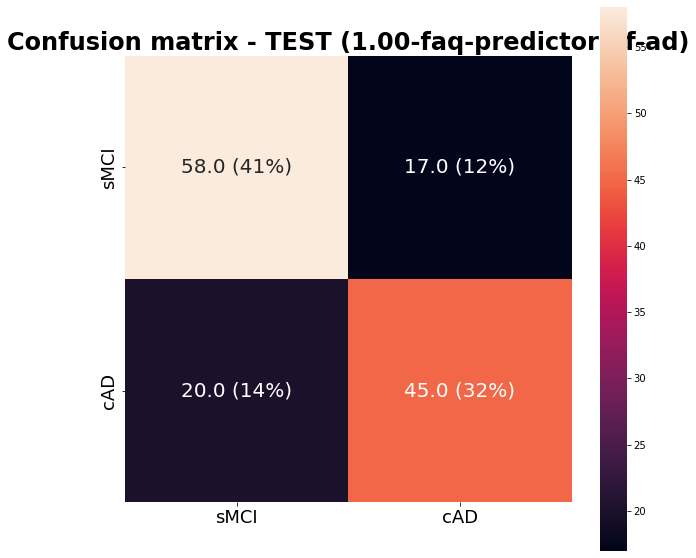

In [21]:
conf_matrix_test  = metrics.confusion_matrix(y_test, y_test_pred)    

# mean of test confusion matrix
conf_mat_mean = conf_matrix_test.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_matrix_test_prc = conf_matrix_test / y_test.shape[0] * 100

ad.plot_confusion_matrix_TEST(conf_matrix_test, conf_matrix_test_prc, file_name_number=FILE_NAME_NUMBER, file_name_prefix=FILE_NAME_PREFIX,
                                 save=False, results_dir=RESULTS_DIR)

## FEATURE IMPORTANCE

In [22]:
X_train_new = ad.rename_columns(X_train, FEATURE_RENAMING, verbose=True) 



OLD names:
Index(['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
       'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds',
       'LRHHC_n_long', 'LRLV_n_long', 'FAQ'],
      dtype='object')

NEW names:
Index(['AGE', 'RAVLT-Im', 'RAVLT-Delay', 'RAVLT-Recog', 'TMTA', 'TMTB', 'CFT',
       'GDS', 'HC', 'LVV', 'FAQ'],
      dtype='object')



In [23]:
X_test_new = ad.rename_columns(X_test, FEATURE_RENAMING, verbose=True) 


OLD names:
Index(['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
       'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds',
       'LRHHC_n_long', 'LRLV_n_long', 'FAQ'],
      dtype='object')

NEW names:
Index(['AGE', 'RAVLT-Im', 'RAVLT-Delay', 'RAVLT-Recog', 'TMTA', 'TMTB', 'CFT',
       'GDS', 'HC', 'LVV', 'FAQ'],
      dtype='object')



In [24]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train_new.columns).sort_values(ascending=False)
print(f'Feature importance for the train set:\n\n{feature_imp.to_string()}')

Feature importance for the train set:

FAQ            0.196961
RAVLT-Im       0.180133
HC             0.150269
RAVLT-Delay    0.131718
TMTA           0.059286
TMTB           0.057993
RAVLT-Recog    0.055087
AGE            0.054757
LVV            0.054042
CFT            0.038786
GDS            0.020969


Mean featue importacne plot saved to:
		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/AV_paper_revision_first_cleaned_20221012/results/1.00-faq-predictor-of-ad-TEST-feat-importance-h.png



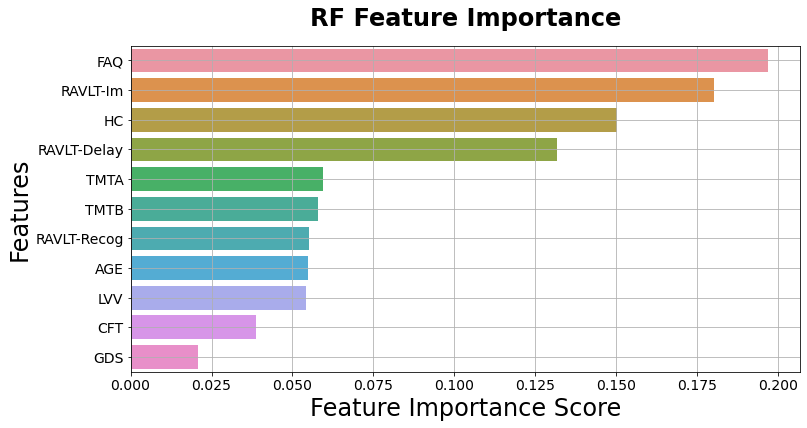

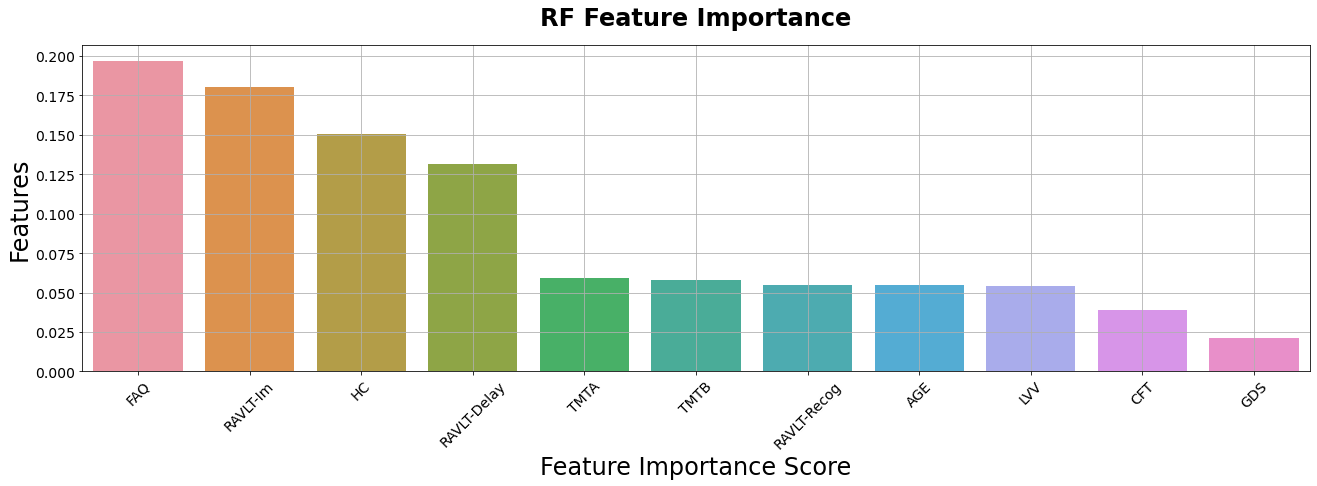

In [25]:
ad.plot_single_feature_importnce(feature_imp,
                                    FILE_NAME_PREFIX, orientation='h', figsize=(12,6), results_dir = RESULTS_DIR, save=True)

ad.plot_single_feature_importnce(feature_imp,
                                    FILE_NAME_PREFIX, orientation='v', figsize=(22,6), results_dir = RESULTS_DIR, save=False)

---

## CORELATION (OPTIONAL)

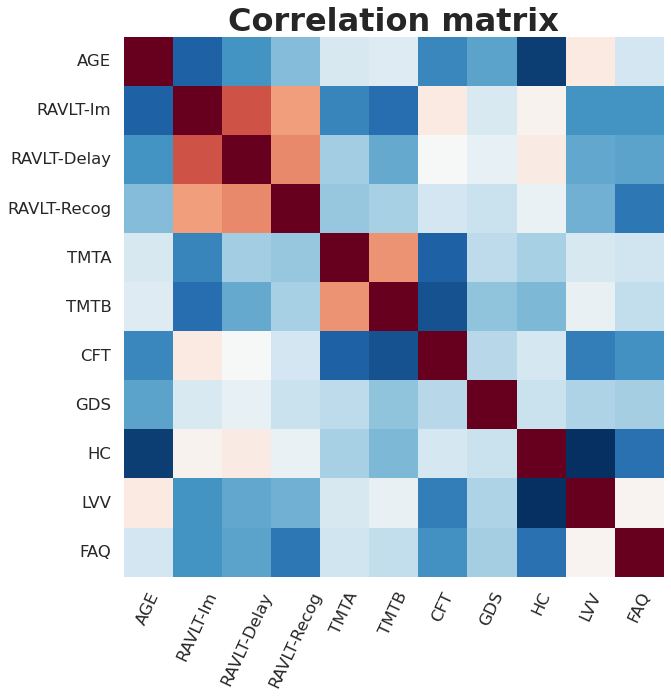

In [54]:
if VERBOSE:
    cor = X_test_new.corr()
    
    mn, mx = cor.values.min(), cor.values.max()
    
    f,ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(20,12))
    sns.heatmap(cor, annot=False, cmap='RdBu_r', ax=ax, vmin=mn, vmax=mx, cbar=False)
    ax.set_aspect(aspect=1)
    
    plt.xticks(rotation=65)
    plt.title('Correlation matrix', fontweight='bold', fontsize=32)
    plt.subplots_adjust(top=0.75)
    
    save_pth = RESULTS_DIR / f"{FILE_NAME_PREFIX}corr_matrix.pdf" 
    plt.savefig(save_pth)

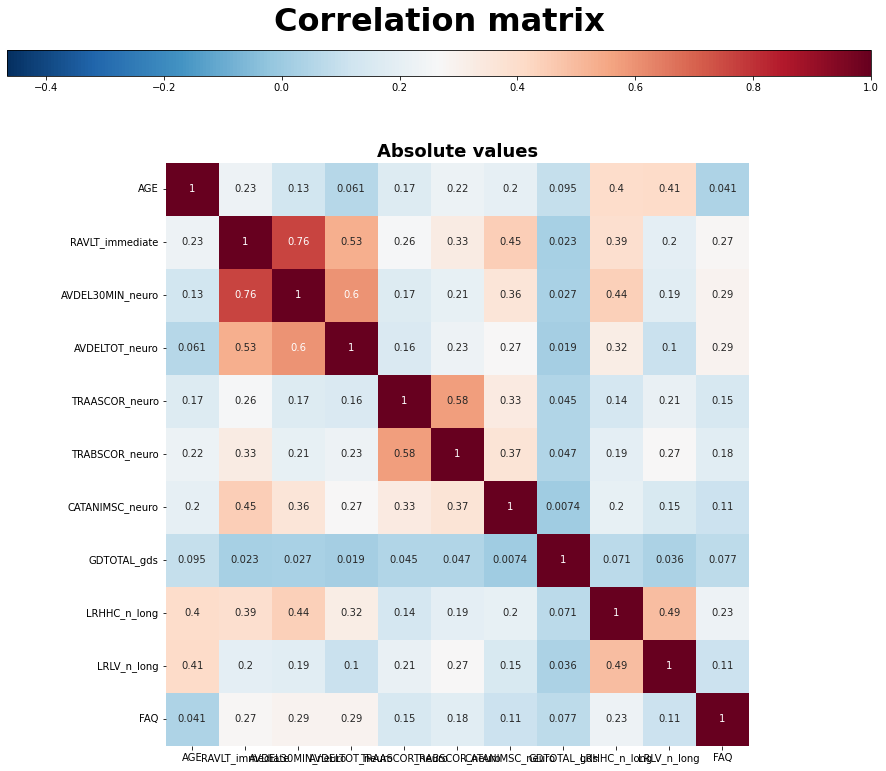

In [27]:
if VERBOSE:
    cor = X_test_new.corr()
    mn, mx = cor.values.min(), cor.values.max()
    cor_abs = X_train.corr().abs()    
    
    
    f,ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(20,12))
    sns.heatmap(cor_abs, annot=True, cmap='RdBu_r', ax=ax, vmin=mn, vmax=mx, cbar=False)
    
    title = 'Absolute values'
      
    ax.set_aspect(aspect=1)
    ax.set_title(title, fontsize=18, fontweight='bold')    
    
    cax = f.add_axes([0.2, 0.90, 0.6, 0.03])
    norm = plt.Normalize(mn, mx)
    sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
    sm.set_array([])
    f.colorbar(sm, cax=cax, orientation='horizontal')

    plt.subplots_adjust(top=0.8)
    plt.suptitle('Correlation matrix', fontsize=32, fontweight='bold')

---

# FEATURE IMPORTANCE (WITH GROUPING)

In [28]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS) 
clf.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=False, max_depth=6, max_features=2,
                       min_samples_leaf=2, n_estimators=65, random_state=42)

### PRINT FEATURES (RECAP)

In [29]:
_=[print(c) for c in X_test.columns] 

AGE
RAVLT_immediate
AVDEL30MIN_neuro
AVDELTOT_neuro
TRAASCOR_neuro
TRABSCOR_neuro
CATANIMSC_neuro
GDTOTAL_gds
LRHHC_n_long
LRLV_n_long
FAQ


# FEATURE PERMUTATION WITHOUT GROUPING

In [30]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=False, max_depth=6, max_features=2,
                       min_samples_leaf=2, n_estimators=65, random_state=42)

---

# FEATURE PERMUTATION WITH GROUPS

Repetition(s) = 2000
Averaging mode!
random_state = None

All features:
	['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long', 'FAQ']

Feature groups:
	['RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro']
	['TRAASCOR_neuro', 'TRABSCOR_neuro']

Single features:
	['AGE', 'CATANIMSC_neuro', 'FAQ', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long']




OLD names:
Index(['Group_0', 'FAQ', 'LRHHC_n_long', 'Group_1', 'CATANIMSC_neuro',
       'GDTOTAL_gds', 'AGE', 'LRLV_n_long'],
      dtype='object')

NEW names:
Index(['RAVLT', 'FAQ', 'HC', 'TMT', 'CTF', 'GDS', 'AGE', 'LVV'], dtype='object')



f1    acc  recall   prec
RAVLT  0.126  0.110   0.127  0.122
FAQ    0.118  0.111   0.108  0.128
HC     0.058  0.054   0.053  0.062
TMT    0.018  0.018   0.014  0.023
CTF    0.011  0.009   0.012  0.010
GDS    0.008  0.006   0.012  0.003
AGE    0.007  0.007   0.007  0.007
LVV   -0.006 -0.002  -0.016  0.005

Shuffle [group] feature(s) saved to:
		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/AV_paper_revision_first_cleaned_20221012/results/1.00-faq-predictor-of-ad-reps-2000-shuffle-features.pdf



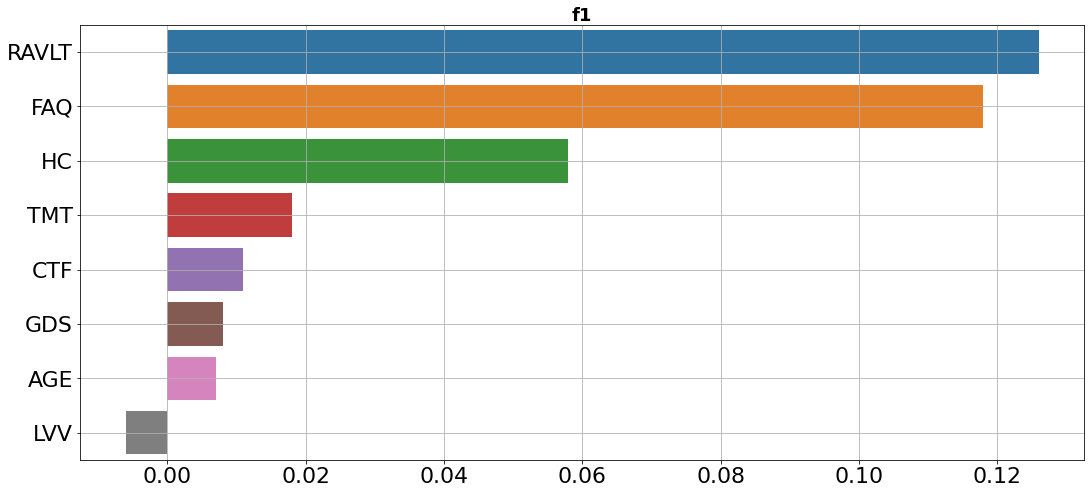

Group_0:['RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro']
Group_1:['TRAASCOR_neuro', 'TRABSCOR_neuro']


In [31]:
reps = 1999
df, features = ad.shuffle_features_with_groups(clf, X_test, y_test,
                                                  precission=3,
                                                  verbose=True,
                                                  random_state=RANDOM_STATE,
                                                  repetitions=reps,
                                                  sortBy='f1',
                                                  ascending=False,
                                                  groups=[['RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro'],
                                                         ['TRAASCOR_neuro','TRABSCOR_neuro']])
    
FEATURE_RENAMING = {"Group_0":"RAVLT", "Group_1":"TMT",
                     'AGE':'AGE', 'CATANIMSC_neuro':'CTF',
                    'FAQ':'FAQ', 'LRHHC_n_long':'HC',
                   'GDTOTAL_gds':'GDS', 'LRLV_n_long':'LVV'}


df1 = ad.rename_columns(df.T, FEATURE_RENAMING, verbose=True)
df1 = df1.T

display(df1)

rep = reps
ad.plot_permuted_features_single(df1,
                                    performance_name = "f1",
                                    file_name_prefix=f'{FILE_NAME_PREFIX}-reps-{rep+1:0>4}',
                                    type='shuffle',
                                    save=True,
                                    results_dir=RESULTS_DIR,
                                    figsize=(18,8)                             
                                    )
ad._print_group_names(features)

---

# DROP SINGLE FEATURE(S)

In [32]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS) 

# DROP GROUP OF FEATURES

In [33]:
df.index.values

array(['Group_0', 'FAQ', 'LRHHC_n_long', 'Group_1', 'CATANIMSC_neuro',
       'GDTOTAL_gds', 'AGE', 'LRLV_n_long'], dtype=object)

All features:
	['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long', 'FAQ']

Feature groups:
	['RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro']
	['TRAASCOR_neuro', 'TRABSCOR_neuro']

Single features:
	['AGE', 'CATANIMSC_neuro', 'FAQ', 'GDTOTAL_gds', 'LRHHC_n_long', 'LRLV_n_long']




OLD names:
Index(['Group_0', 'Group_1', 'AGE', 'CATANIMSC_neuro', 'FAQ', 'GDTOTAL_gds',
       'LRHHC_n_long', 'LRLV_n_long'],
      dtype='object')

NEW names:
Index(['RAVLT', 'TMT', 'AGE', 'CFT', 'FAQ', 'GDS', 'HC', 'LVV'], dtype='object')



f1      acc   recall     prec
RAVLT  0.08851  0.08571  0.07692  0.10081
FAQ    0.05750  0.05714  0.04615  0.06956
TMT    0.05266  0.04286  0.06154  0.04247
HC     0.04724  0.04286  0.04615  0.04839
AGE    0.00637  0.01429 -0.01538  0.02884
GDS    0.00554  0.00714  0.00000  0.01152
LVV   -0.00890  0.00000 -0.03077  0.01369
CFT   -0.01009 -0.00714 -0.01538 -0.00435

Shuffle [group] feature(s) saved to:
		/home/marek/Dropbox/p1ext4_P/no_work/MCI/MCI-subgroups/AV_paper_revision_first_cleaned_20221012/results/1.00-faq-predictor-of-ad-drop-features.pdf



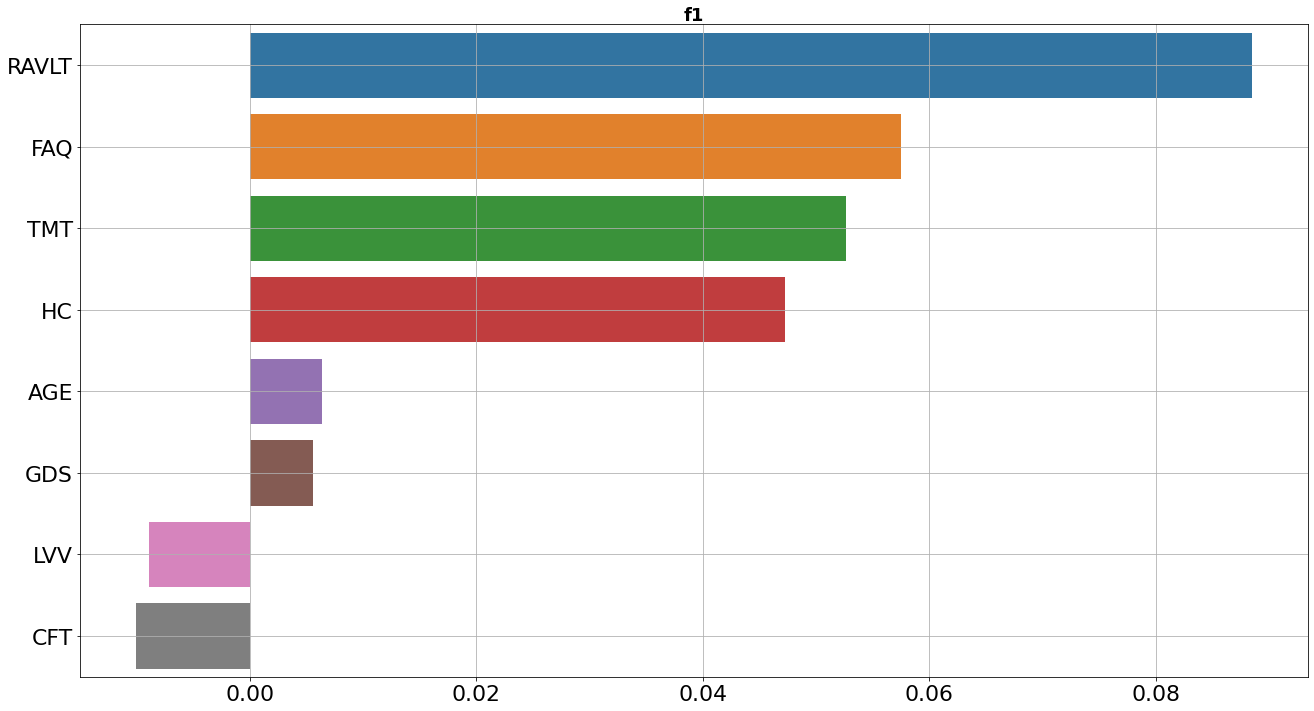

Group_0:['RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro']
Group_1:['TRAASCOR_neuro', 'TRABSCOR_neuro']


In [34]:
df, features = ad.dropcol_importances(clf, X_train, y_train, X_test, y_test, precission=5, verbose=True,
                                         groups=[['RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro'],
                                                 ['TRAASCOR_neuro','TRABSCOR_neuro']])

FEATURE_RENAMING = {"Group_0":"RAVLT", "Group_1":"TMT",
                     'AGE':'AGE', 'CATANIMSC_neuro':'CFT',
                    'FAQ':'FAQ','GDTOTAL_gds':'GDS', 'LRLV_n_long':'LVV', 'LRHHC_n_long':'HC'}

df1 = ad.rename_columns(df.T, FEATURE_RENAMING, verbose=True)
df1 = df1.T
df1.sort_values('f1', inplace=True, ascending=False)

display(df1)

ad.plot_permuted_features_single(df1, "f1", file_name_prefix=FILE_NAME_PREFIX,
                                    type='drop', save=True, results_dir=RESULTS_DIR)
ad._print_group_names(features)

# SHAP VALUES

In [35]:
import shap

import numpy as np
np.set_printoptions(formatter={'float':lambda x:"{:.4f}".format(x)})
import pandas as pd
pd.options.display.float_format = "{:.3f}".format
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid', context='talk', palette='rainbow')

shap.initjs()

In [36]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=6, max_features=2,
                       min_samples_leaf=2, n_estimators=65, random_state=42)

In [37]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_test_new)

In [38]:
print(shap_values.values.shape)
print(shap_values.base_values.shape)
print(explainer.expected_value.shape)

(140, 11, 2)
(140, 2)
(2,)


In [39]:
explainer = shap.Explainer(clf)
shap_test = explainer(X_test_new)
print(f"Shap values length: {len(shap_test)}\n")
print(f"Sample shap value:\n{shap_test[0]}")

Shap values length: 140

Sample shap value:
.values =
array([[-0.0175, 0.0175],
       [-0.0564, 0.0564],
       [-0.0246, 0.0246],
       [-0.0234, 0.0234],
       [-0.0031, 0.0031],
       [-0.0044, 0.0044],
       [-0.0005, 0.0005],
       [0.0015, -0.0015],
       [-0.1103, 0.1103],
       [-0.0120, 0.0120],
       [0.1399, -0.1399]])

.base_values =
array([0.5278, 0.4722])

.data =
array([80.4000, 30.0000, 1.0000, 7.0000, 49.0000, 168.0000, 13.0000,
       0.0000, 0.0036, 0.0269, 0.0000])


In [40]:
print(f"Expected value: {explainer.expected_value[0]:.1f}")
print(f"Average target value (training data): {y_train.mean():.1f}")
print(f"Base value: {np.unique(shap_test.base_values)[0]:.1f}")

Expected value: 0.5
Average target value (training data): 0.5
Base value: 0.5


In [41]:
(shap_test.data == X_test_new).describe()

AGE RAVLT-Im RAVLT-Delay RAVLT-Recog  TMTA  TMTB   CFT   GDS    HC  \
count    140      140         140         140   140   140   140   140   140   
unique     1        1           1           1     1     1     1     1     1   
top     True     True        True        True  True  True  True  True  True   
freq     140      140         140         140   140   140   140   140   140   

         LVV   FAQ  
count    140   140  
unique     1     1  
top     True  True  
freq     140   140

In [42]:
pd.DataFrame(shap_test.data, columns=shap_test.feature_names, index=X_test_new.index)

AGE  RAVLT-Im  RAVLT-Delay  RAVLT-Recog    TMTA    TMTB    CFT   GDS  \
6    80.400    30.000        1.000        7.000  49.000 168.000 13.000 0.000   
82   77.300    29.000        0.000       11.000 122.000 151.000 17.000 2.000   
184  77.500    35.000        1.000       10.000  27.000  69.000 24.000 2.000   
359  71.100    24.000        0.000        2.000  50.000  85.000 13.000 2.000   
384  83.600    30.000        2.000        9.000  22.000  76.000 18.000 0.000   
...     ...       ...          ...          ...     ...     ...    ...   ...   
6261 69.300    49.000        6.000       11.000  24.000  99.000 17.000 1.000   
6267 60.100    51.000       10.000       15.000  28.000  57.000 22.000 2.000   
6291 71.500    34.000        7.000       13.000  50.000 127.000 16.000 1.000   
6304 80.200    25.000        0.000       10.000  31.000  73.000  8.000 1.000   
6309 68.800    29.000        1.000       11.000  28.000  66.000 13.000 1.000   

        HC   LVV    FAQ  
6    0.004 0.027  0.000  
82   0.003 0.076  7.000  
184  0.003 0.024  0.000  
359  0.004 0.022  3.000  
384  0.004 0.019  0.000  
...    ...   ...    ...  
6261 0.004 0.056 13.000  
6267 0.005 0.011  0.000  
6291 0.005 0.028  5.000  
6304 0.004 0.055  9.000  
6309 0.005 0.015  0.000  

[140 rows x 11 columns]

In [43]:
shap_df = pd.DataFrame(shap_test.values[:,:,1],
                       columns=shap_test.feature_names,
                       index=X_test.index)
shap_df

AGE  RAVLT-Im  RAVLT-Delay  RAVLT-Recog   TMTA   TMTB    CFT    GDS  \
6     0.017     0.056        0.025        0.023  0.003  0.004  0.001 -0.002   
82    0.012     0.044        0.058        0.008  0.021  0.005  0.004  0.004   
184  -0.003     0.044        0.028       -0.001 -0.036 -0.002 -0.014  0.001   
359   0.015     0.055        0.063        0.032  0.007  0.004  0.000  0.002   
384  -0.004     0.061        0.007        0.014 -0.052  0.000  0.003 -0.003   
...     ...       ...          ...          ...    ...    ...    ...    ...   
6261  0.012    -0.142       -0.043        0.017 -0.083  0.002  0.007  0.004   
6267  0.001    -0.106       -0.064       -0.017 -0.013 -0.027 -0.019 -0.001   
6291  0.011     0.055       -0.115       -0.016  0.000 -0.004  0.008  0.005   
6304  0.011     0.053        0.059        0.008  0.013  0.013  0.023  0.007   
6309  0.006     0.050        0.037        0.002 -0.034  0.004 -0.001  0.002   

         HC    LVV    FAQ  
6     0.110  0.012 -0.140  
82    0.085 -0.037  0.096  
184   0.120  0.009 -0.150  
359   0.064  0.008  0.059  
384   0.094  0.002 -0.117  
...     ...    ...    ...  
6261  0.082 -0.029  0.136  
6267 -0.070 -0.001 -0.092  
6291 -0.106 -0.004  0.093  
6304  0.043 -0.067  0.114  
6309 -0.097 -0.001 -0.161  

[140 rows x 11 columns]

In [44]:
np.isclose(clf.predict_proba(X_test)[:,1],
          explainer.expected_value[1] + shap_df.sum(axis=1))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

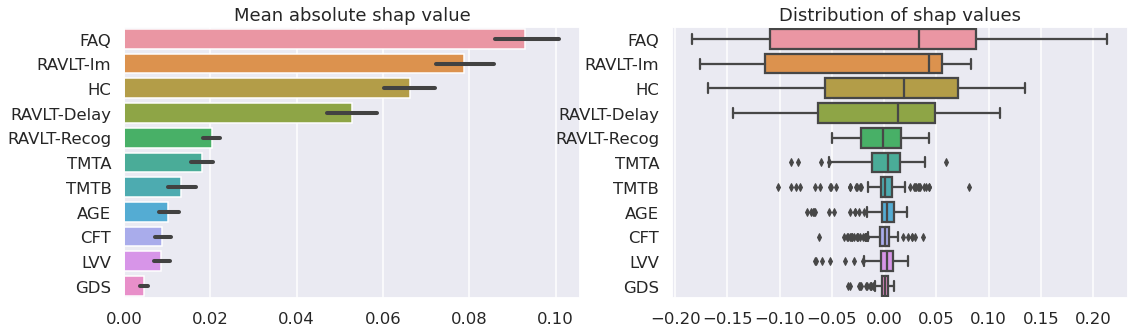

In [45]:
columns = shap_df.apply(np.abs).mean()\
                 .sort_values(ascending=False).index
fig, ax = plt.subplots(1, 2, figsize=(18,5))
sns.barplot(data=shap_df[columns].apply(np.abs), orient='h', 
            ax=ax[0])
ax[0].set_title("Mean absolute shap value")

sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
ax[1].set_title("Distribution of shap values");

In [46]:
# shap.plots.bar(shap_test[:,:,1], max_display=11)
# print(shap_test.mean)

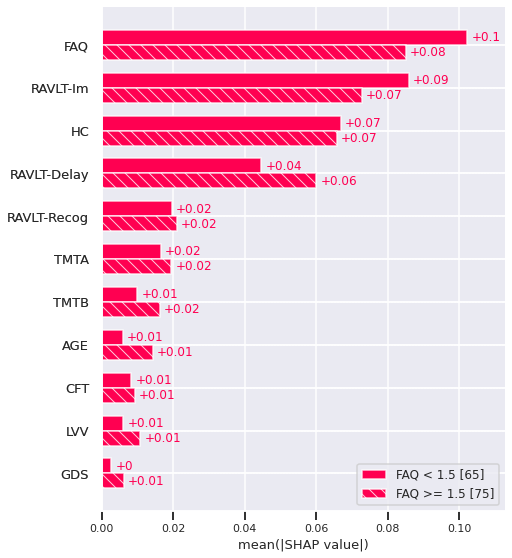

In [47]:
shap.plots.bar(shap_test[:,:,1].cohorts(2).abs.mean(0), max_display=11, show=False) 
plt.subplots_adjust(left=0.2)
f = plt.gcf()

pth = RESULTS_DIR / "shap_cohorts.pdf"
f.savefig(pth)

In [48]:
shap_values = explainer.shap_values(X_test_new)

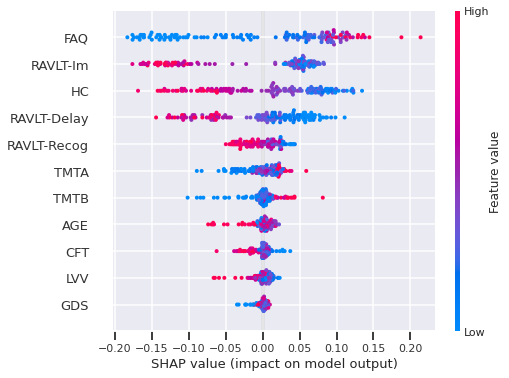

In [49]:
shap.summary_plot(shap_values[1], X_test_new, show=False)

plt.subplots_adjust(left=0.2)
f = plt.gcf()

pth = RESULTS_DIR / "shap_summary.pdf"
f.savefig(pth)

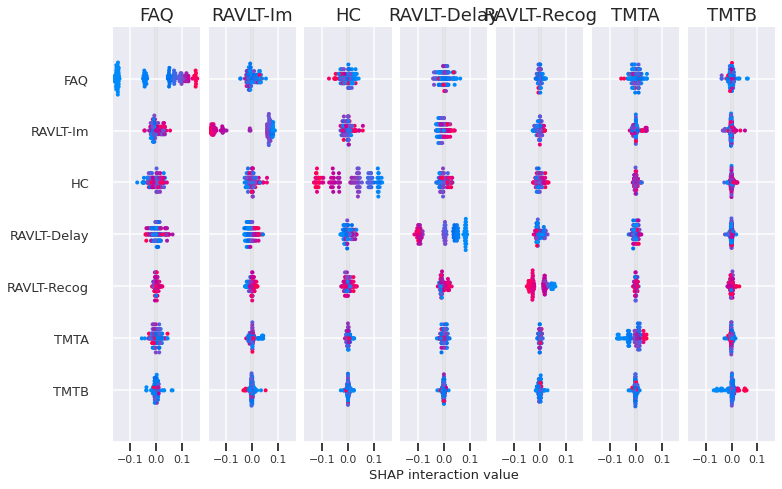

In [50]:
shap_interaction_values = explainer.shap_interaction_values(X)

# Summarize the interaction values
shap.summary_plot(shap_interaction_values[1], X_test_new, show=False)

plt.subplots_adjust(left=0.2)
f = plt.gcf()

pth = RESULTS_DIR / "shap_interaction.pdf"
f.savefig(pth)    

## PDP & ICE PLOTS

In [51]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=6, max_features=2,
                       min_samples_leaf=2, n_estimators=65, random_state=42)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


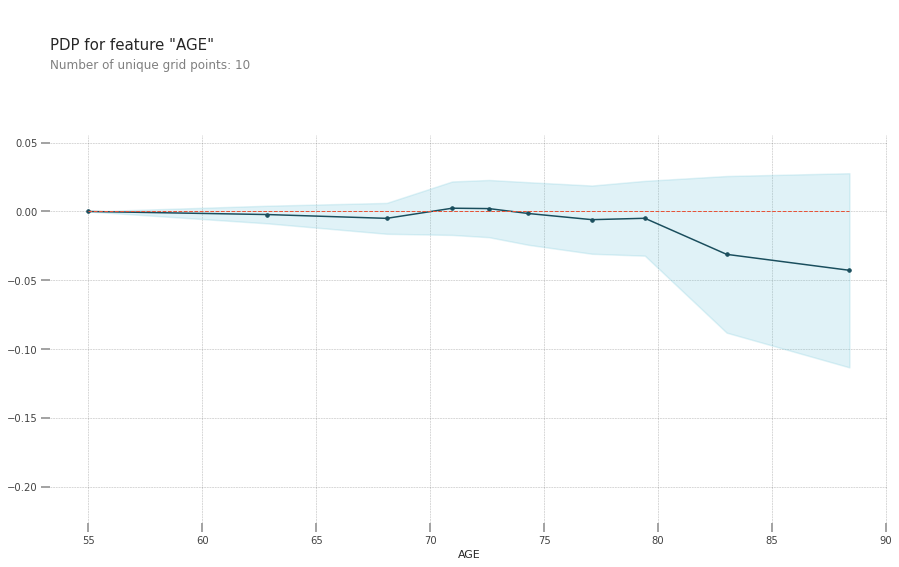

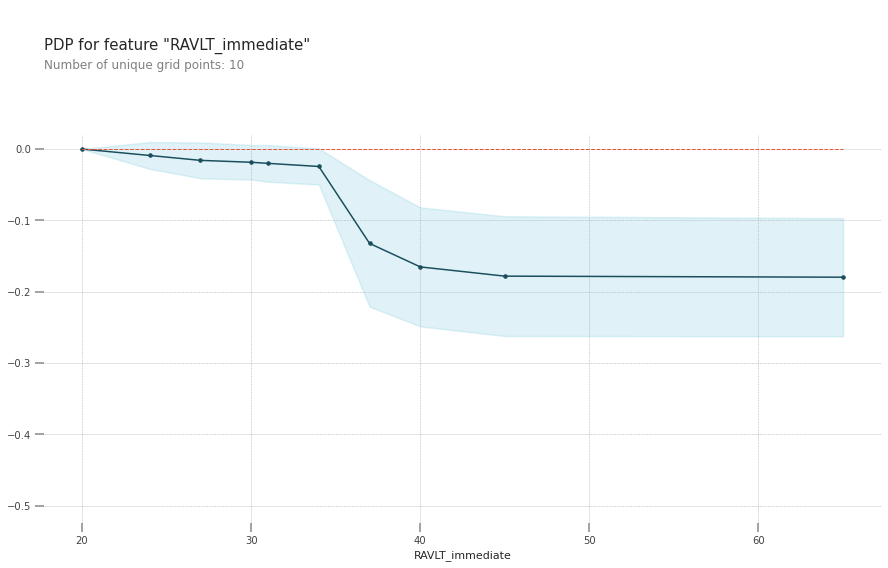

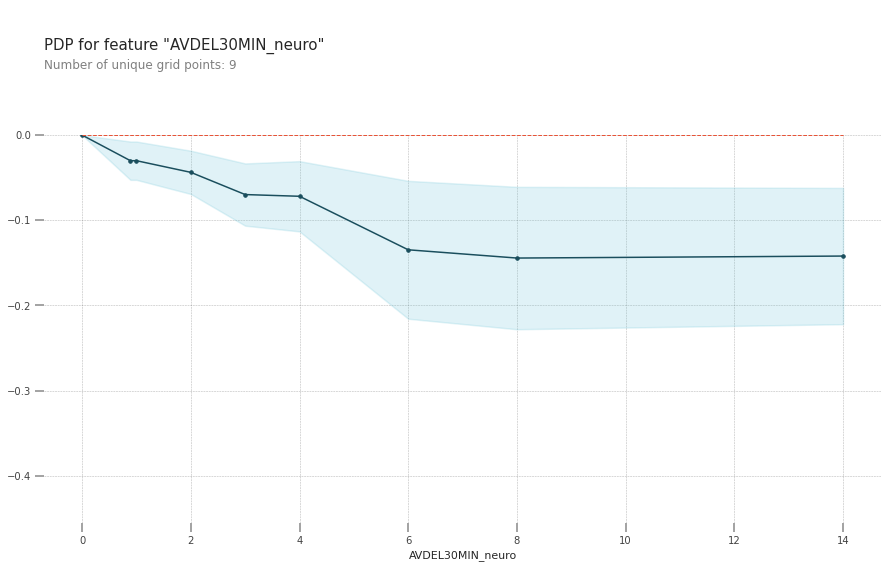

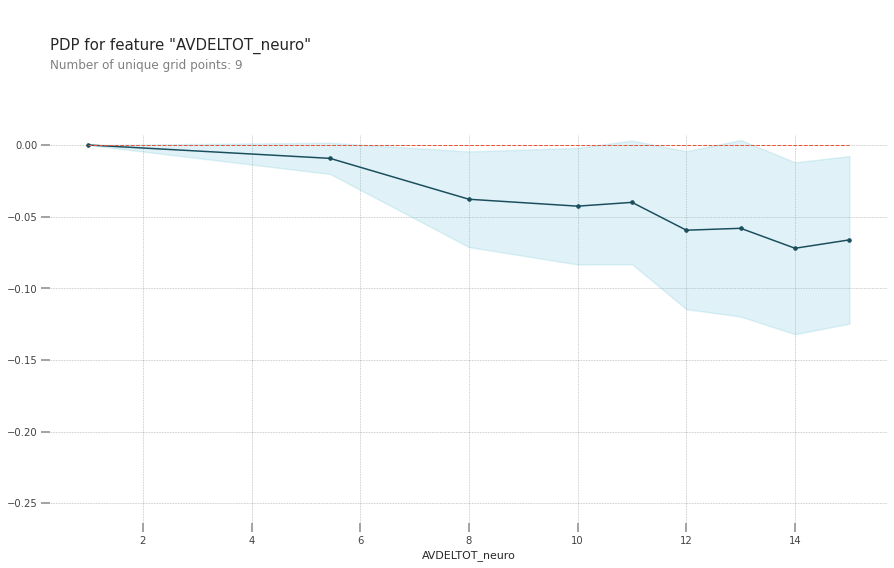

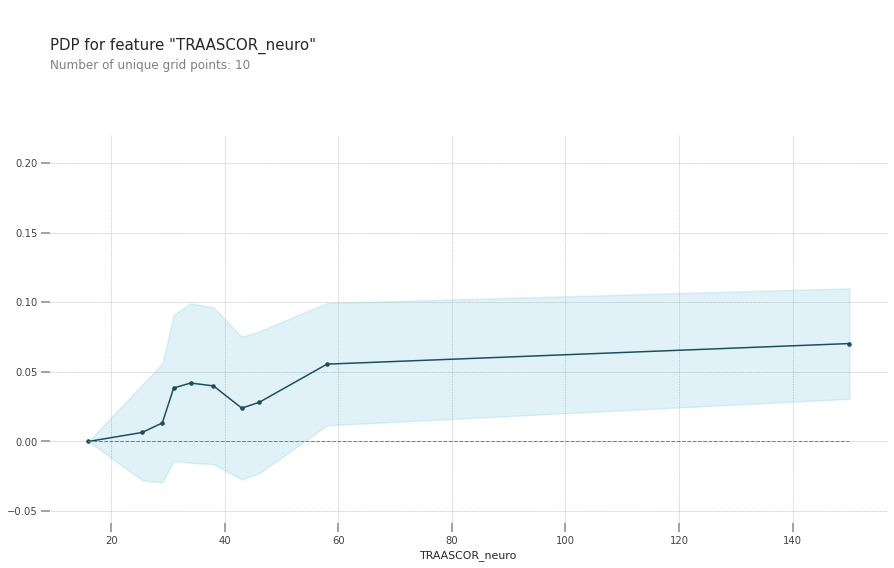

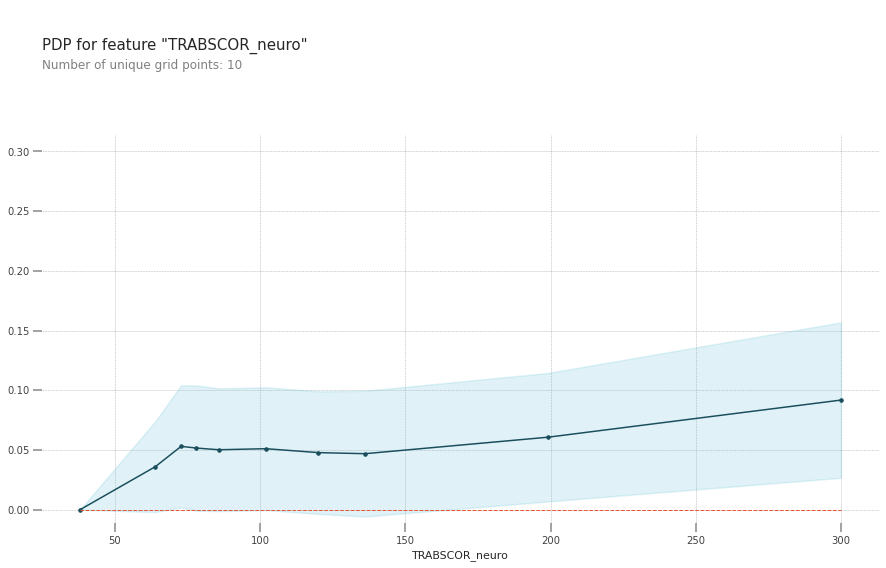

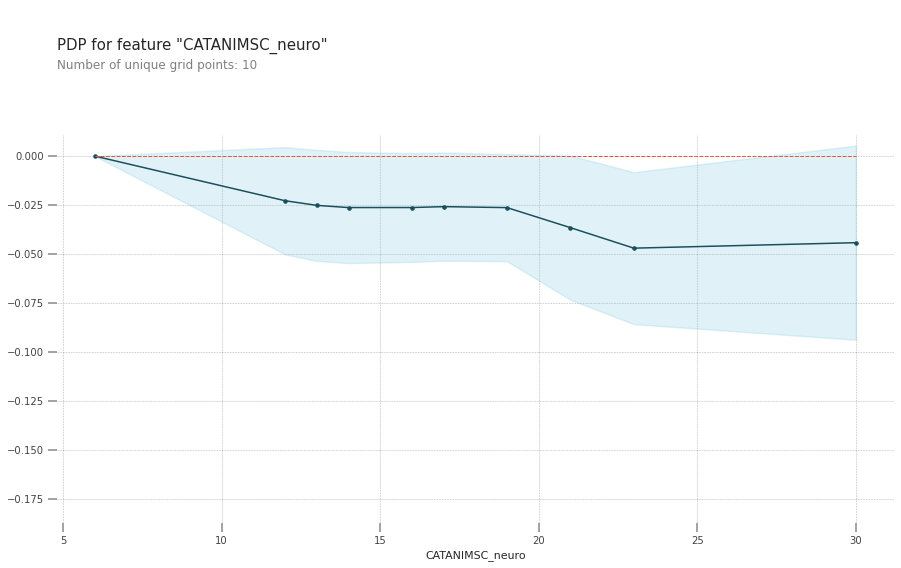

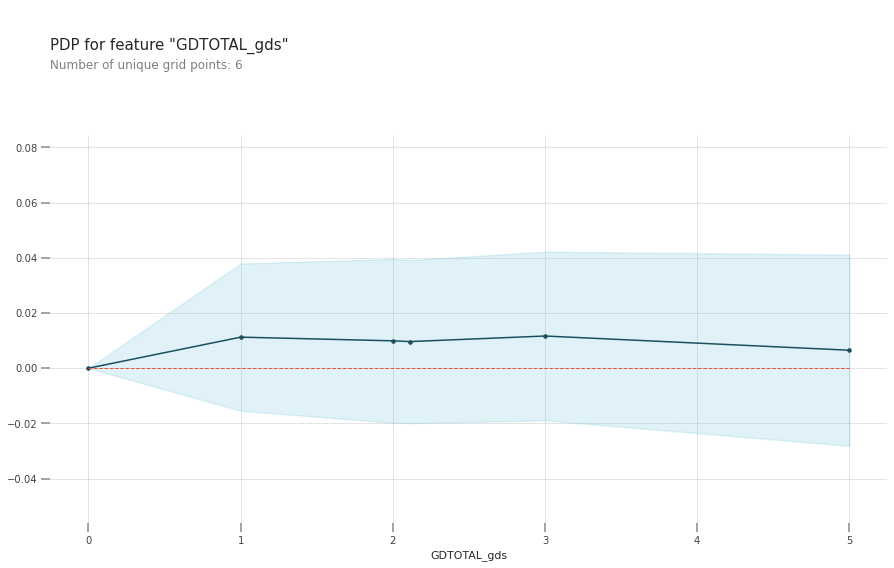

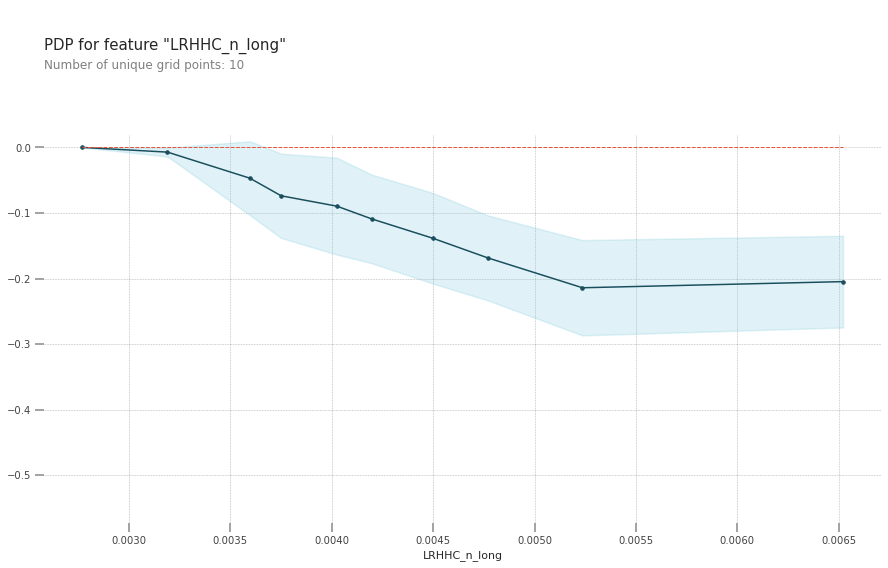

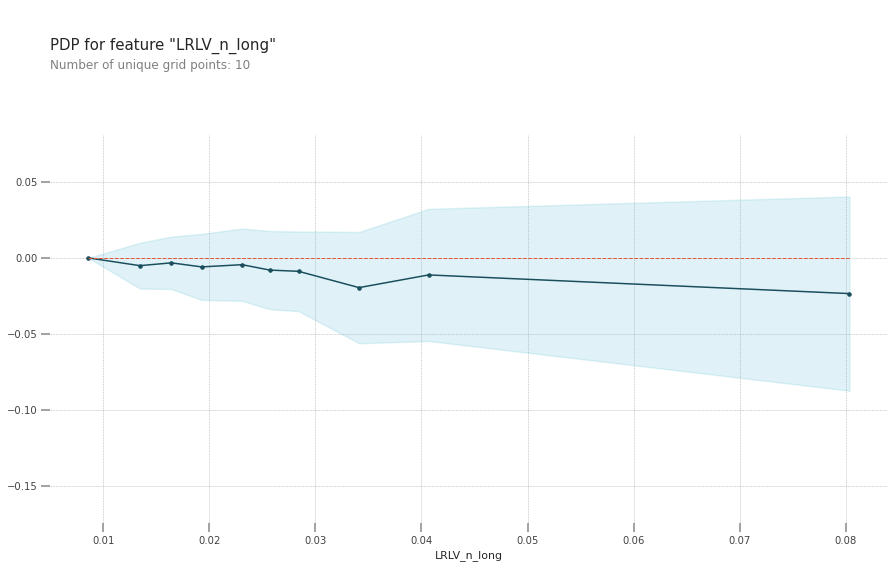

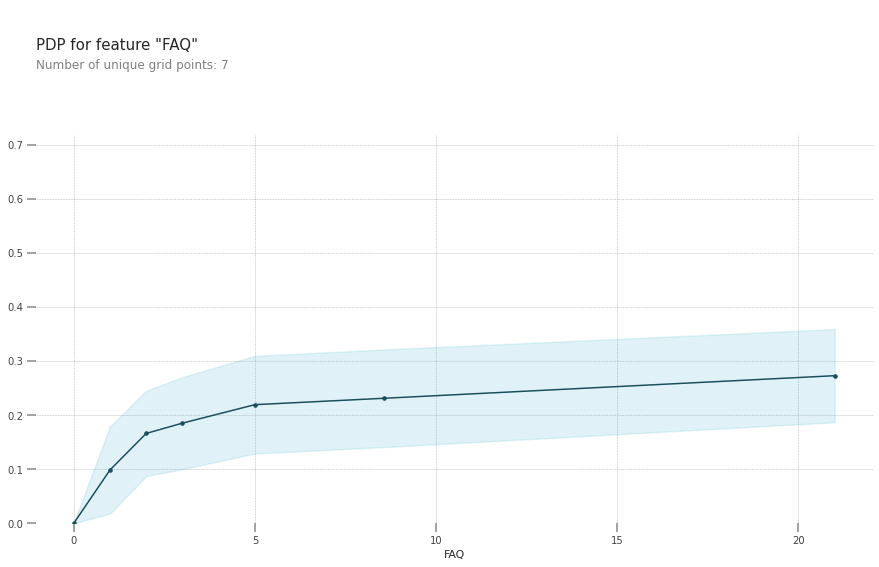

In [52]:
for feature in X_test.columns:
    pdp_goals = pdp.pdp_isolate(model=clf, dataset=X_test, model_features=X_test.columns.tolist(),
                                feature=feature)    
    pdp.pdp_plot(pdp_goals, feature)

    file_name_prefix_ext = f'{FILE_NAME_PREFIX}-pdp-TEST-{feature}.pdf'
    file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
    plt.savefig(file_name_prefix_path)

    plt.show()

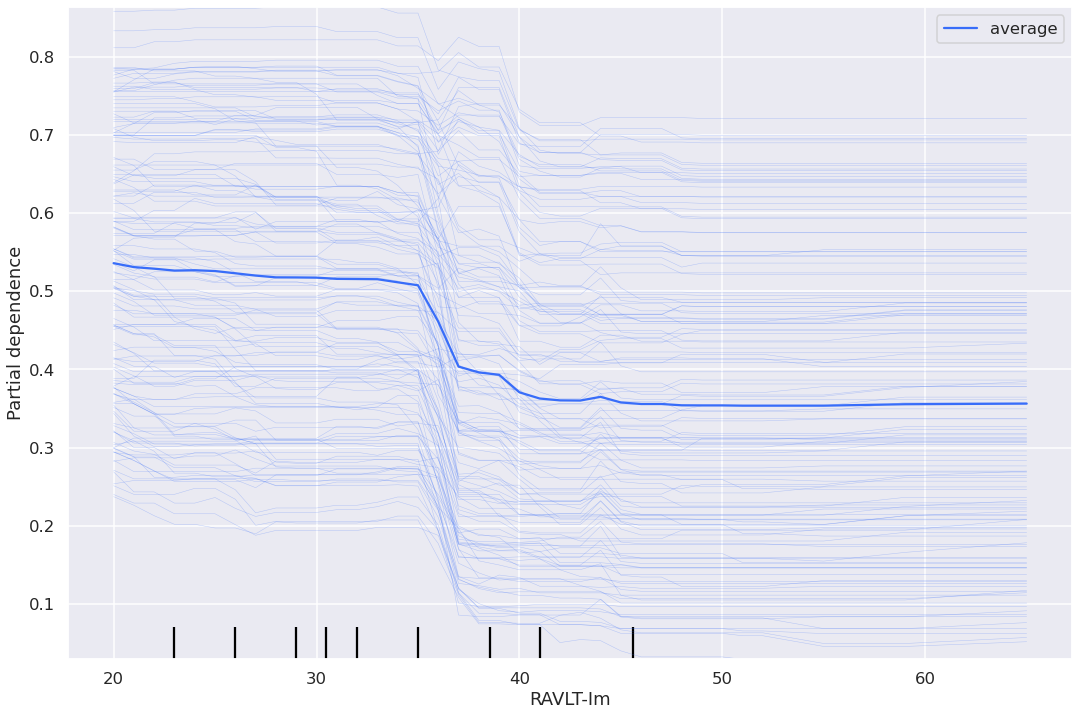

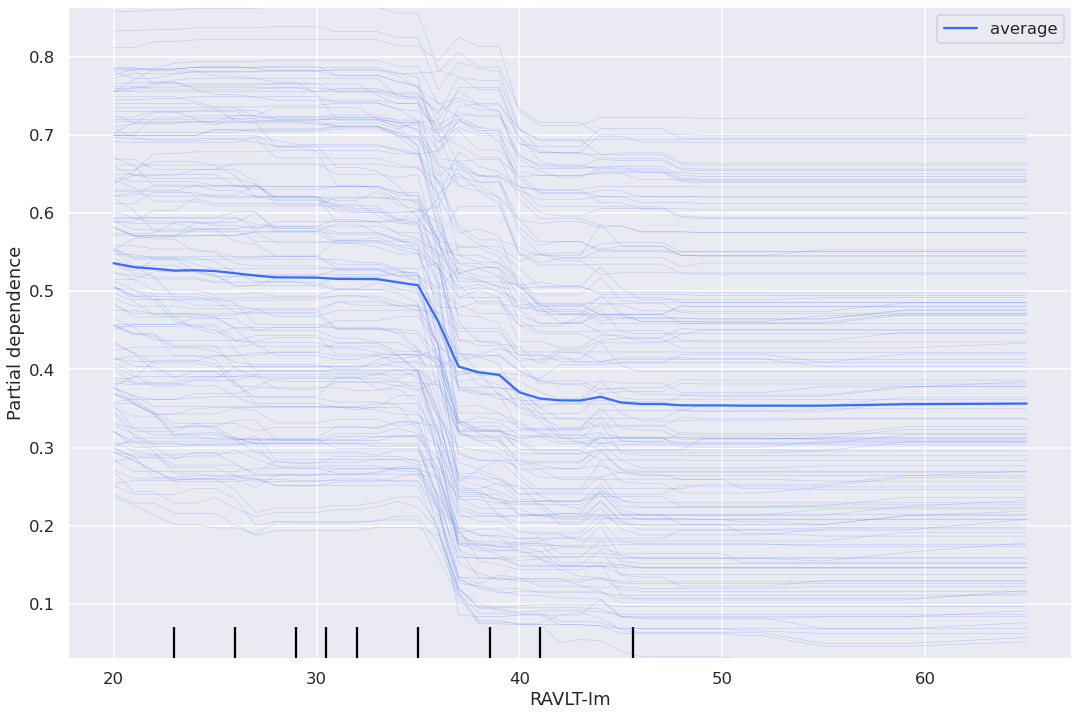

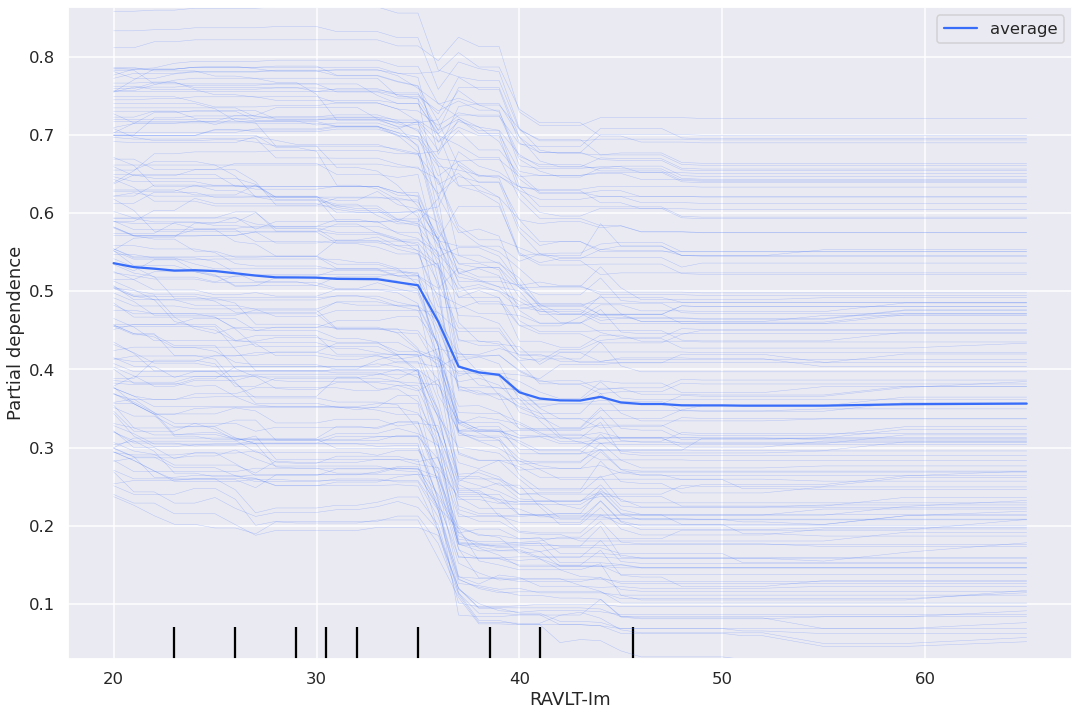

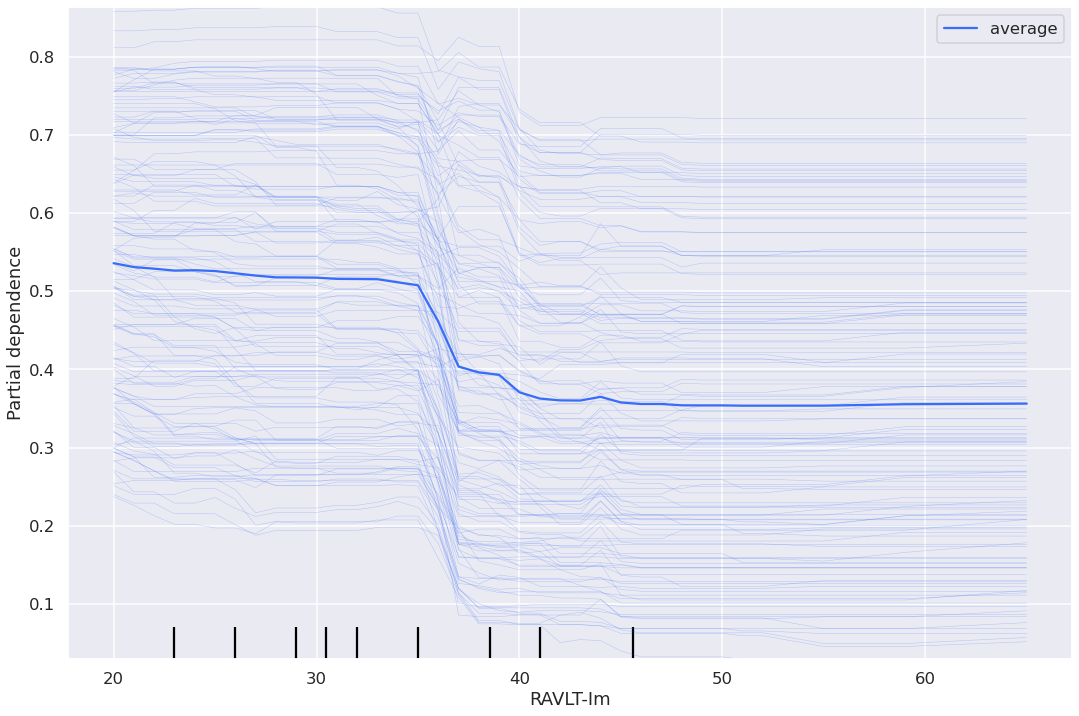

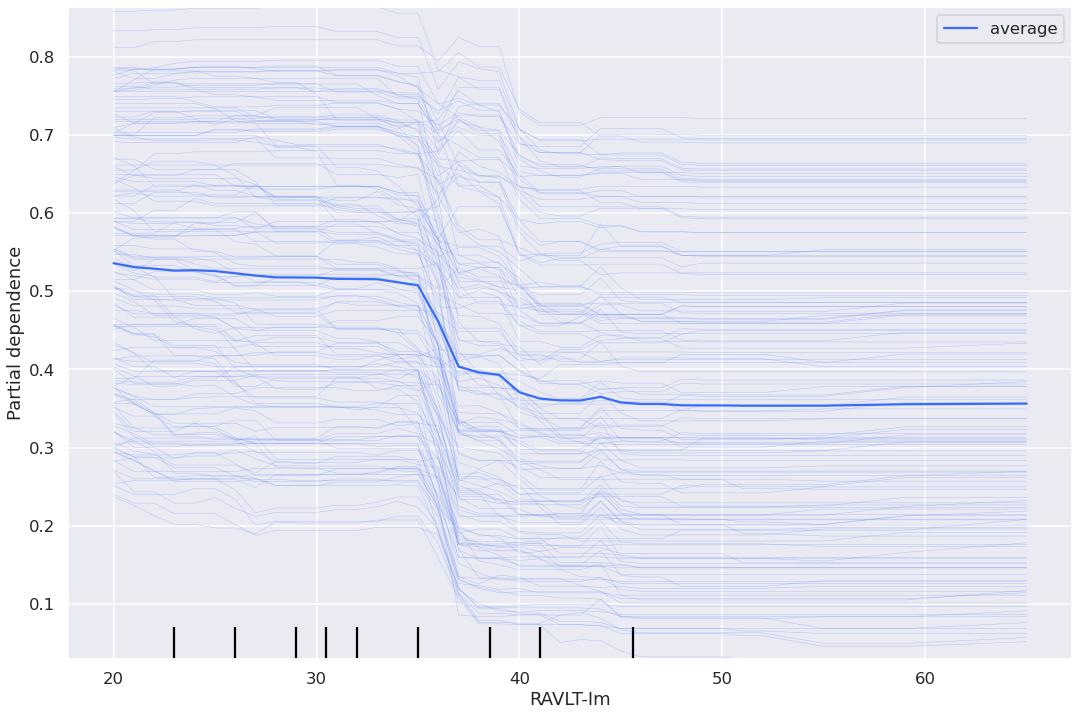

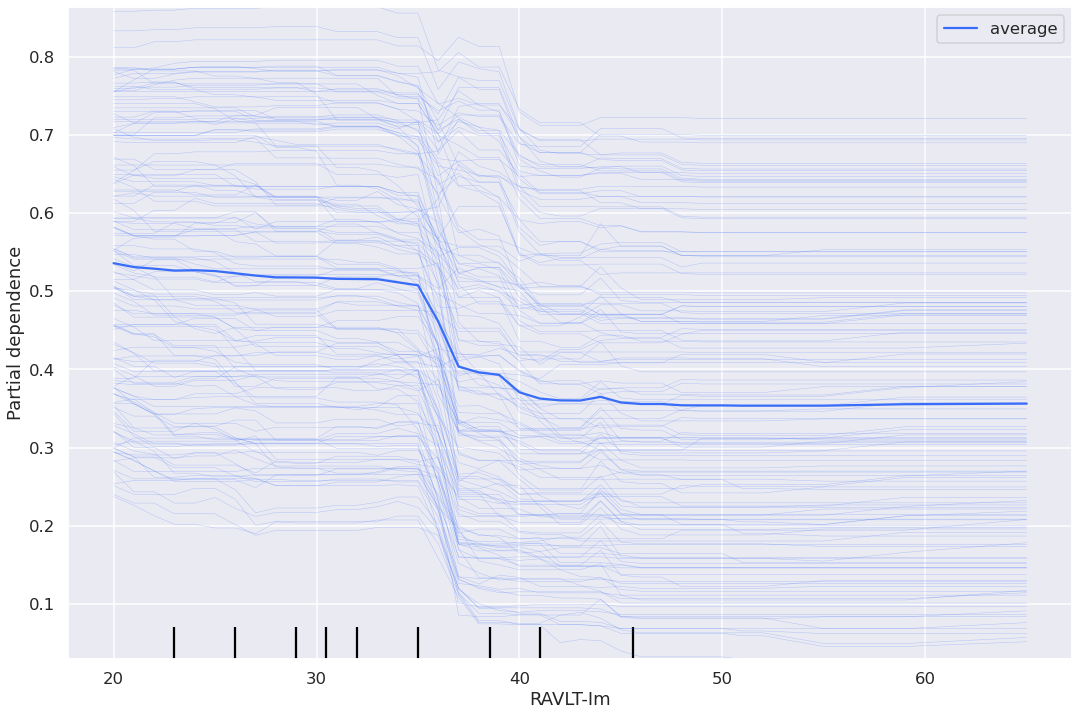

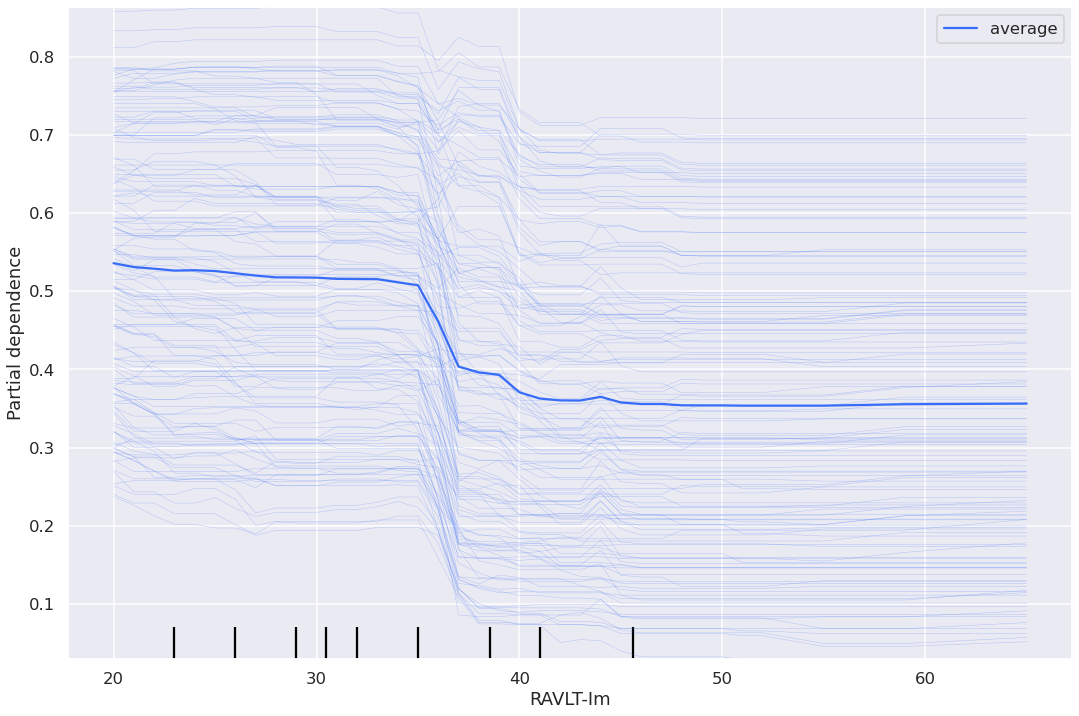

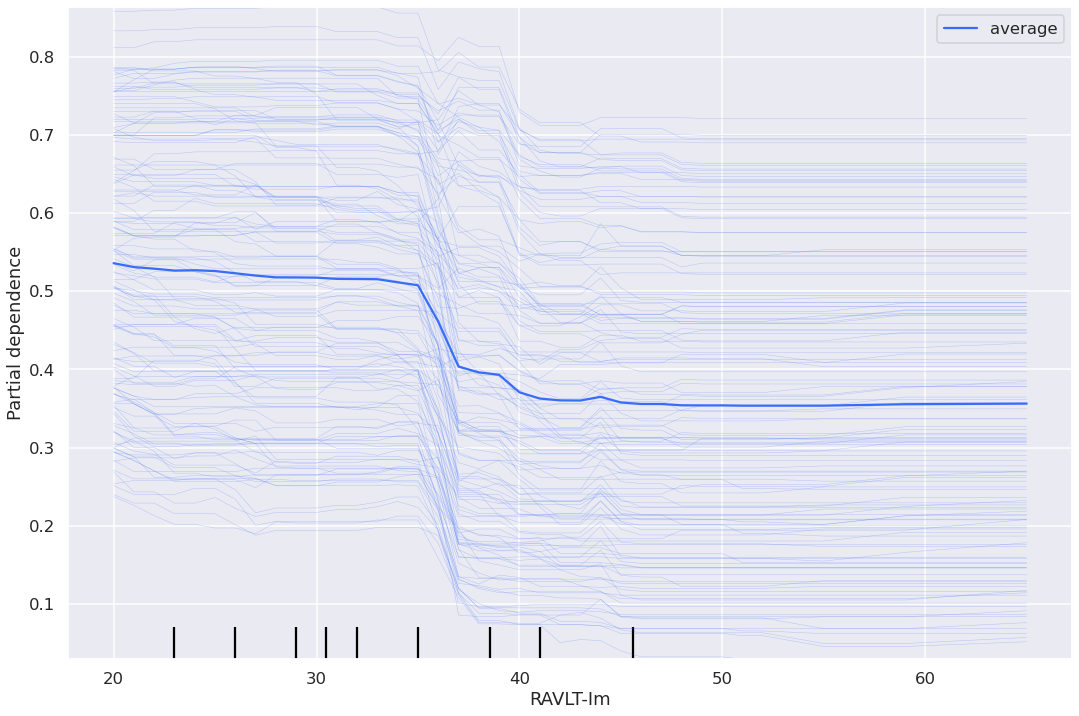

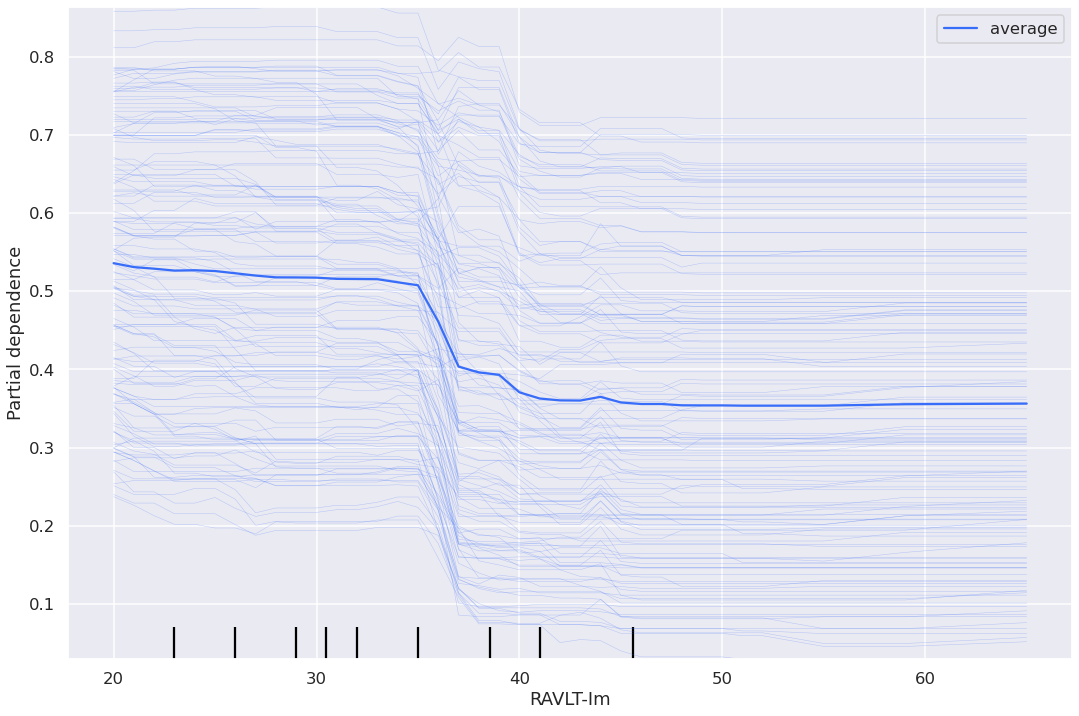

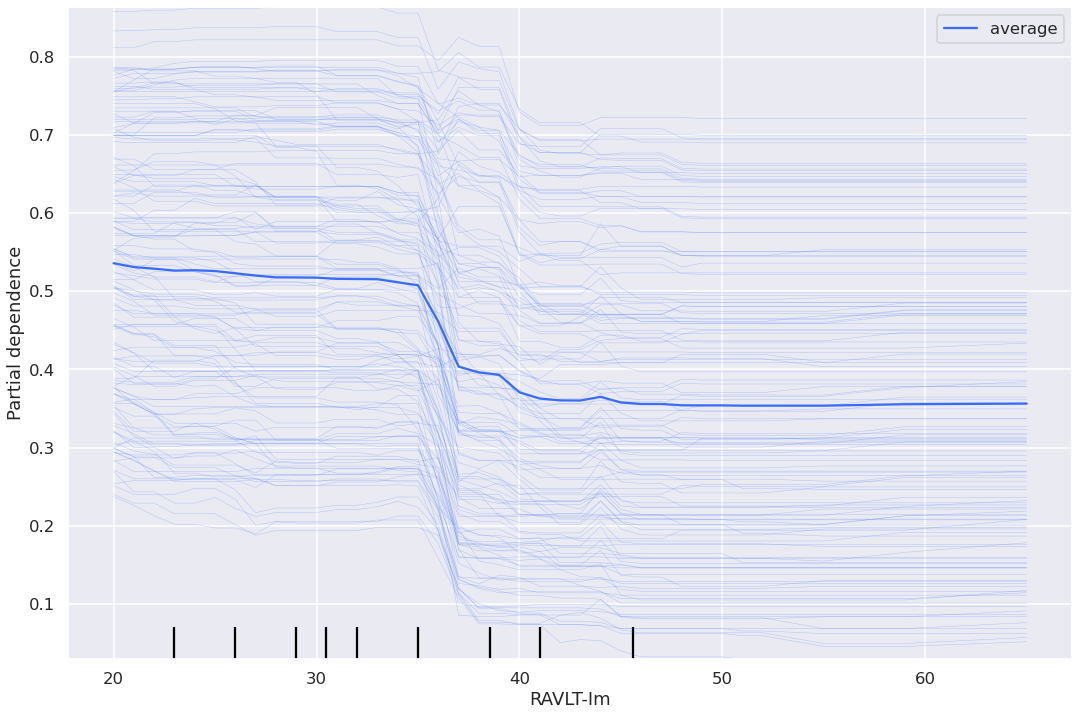

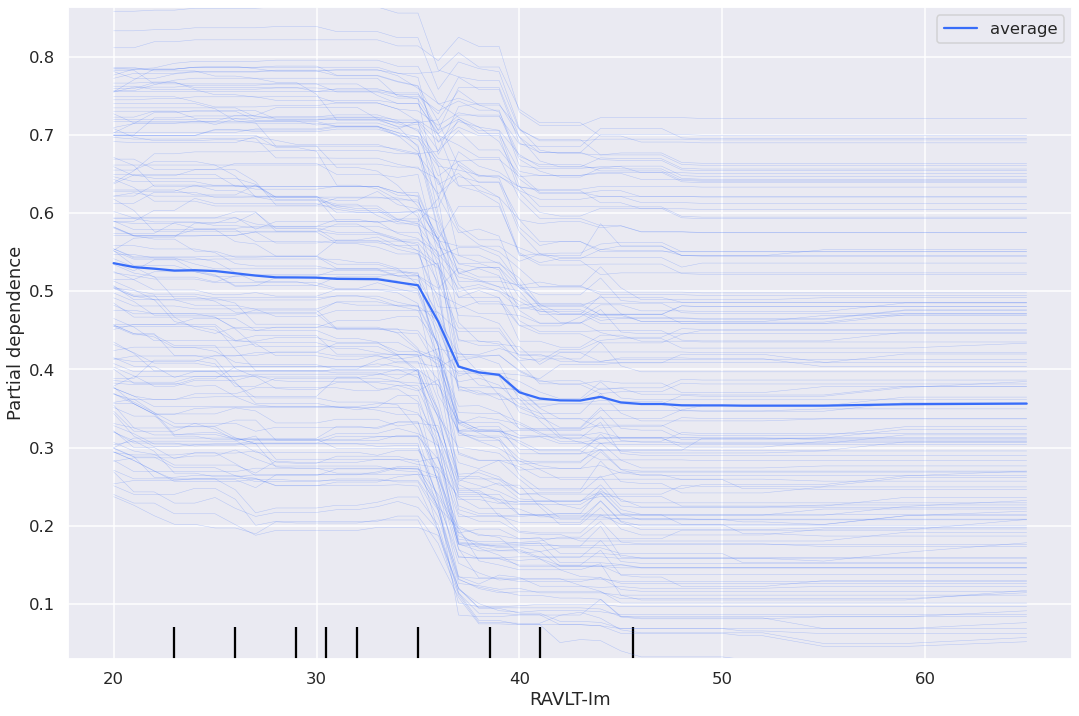

In [53]:
for feature in X_test_new.columns:
    fig,ax = plt.subplots(figsize=(18,12))
    _=plot_partial_dependence(clf, X_test_new, features=['RAVLT-Im'], kind='both', ax=ax)

    file_name_prefix_ext = f'{FILE_NAME_PREFIX}-ICE-TEST-{feature}.pdf'
    file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
    plt.savefig(file_name_prefix_path)

    plt.show()